In [ ]:
from langchain_openai import ChatOpenAI
from langchain import hub
from langgraph_supervisor import create_supervisor
from langgraph.prebuilt import create_react_agent

from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
from langchain_community.tools import TavilySearchResults
from langchain_community.agent_toolkits import create_sql_agent, SQLDatabaseToolkit
from langchain_community.utilities import SQLDatabase
from langchain_pinecone import PineconeVectorStore
from langchain_openai import OpenAIEmbeddings
from pinecone import Pinecone


In [72]:
# Initialize model
model = ChatOpenAI(model="gpt-4o-mini")

In [ ]:
pc = Pinecone()
index = pc.Index(index_name)

vector_store = PineconeVectorStore(embedding=embeddings, index=index)

In [74]:
db = SQLDatabase.from_uri("sqlite:///db/product_demo.db")
# print(db.dialect)
# print(db.get_usable_table_names())
# db.run("SELECT * FROM Products LIMIT 10;")

In [ ]:
sql_toolkit = SQLDatabaseToolkit(db=db, llm=model)

web_search = TavilySearchResults(
        max_results=5,
        search_depth="advanced",
        include_answer=True,
        include_raw_content=True,
        include_images=False,
        # include_domains=[...],
        # exclude_domains=[...],
        # name="...",            # overwrite default tool name
        # description="...",     # overwrite default tool description
        # args_schema=...,       # overwrite default args_schema: BaseModel
    )

/Users/nizar/Documents/Projects/langgraph-fullstack-python/.venv/lib/python3.12/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


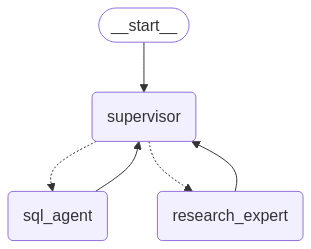

In [68]:
research_agent = create_react_agent(
    model=model,
    tools=[web_search],
    name="research_expert",
    prompt="You are a world class researcher with access to web search. Do not do any math."
)

prompt_template = hub.pull("langchain-ai/sql-agent-system-prompt")  
system_message = prompt_template.format(dialect="SQLite", top_k=5) 

sql_agent = create_react_agent(
    model=model, 
    name='sql_agent',
    tools=sql_toolkit.get_tools(),
    prompt=system_message
)

# Create supervisor workflow
workflow = create_supervisor(
    [research_agent, sql_agent],
    model=model,
    prompt=(
        "You are a team supervisor managing a research expert and a sql expert connected to a product database."
        "For current events, use research_agent. "
        "For learning about products from database use sql_agent."
    )
)


app = workflow.compile()

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [69]:
result = app.invoke({
    "messages": [
        {
            "role": "user",
            "content": "What is your most cheapest product?"
        }
    ]
})

In [70]:
result

{'messages': [HumanMessage(content='What is your most cheapest product?', additional_kwargs={}, response_metadata={}, id='c821c848-3590-4509-98a0-ca09563d5f83'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1dZaC74BBFX3AqvNgF04mhZX', 'function': {'arguments': '{}', 'name': 'transfer_to_sql_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 100, 'total_tokens': 113, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervisor', id='run-260e8ee1-b5a3-4066-8a9c-99d5b719df66-0', tool_calls=[{'name': 'transfer_to_sql_agent', 'args': {}, 'id': 'call_1dZaC74BBFX3AqvNgF04mhZX', 'type': 'tool_call'}], usage_me